# Recomender engine for music box

#### Author: Xi (Cassie) Guo

## Purpose

Building a recommendation system to recommend songs for users on music box

## Data

There are three types of data

* play: id of songs played, user id, song type, etc
* search: query of searches, user id, search time, etc
* download: id of songs downloaded, user id, etc

## What is the target?

* In this exercise, the target is implicit
    * We have use the frequency of play for each song (for each user) during 3.30 - 4.30 and added the weighted count of download songs and use the quantile discretization to generate ratings.
    * For each song, the combined count is:
    $$ count = count(play) + 6*count(download) $$
    
    and we use quantile as dividing point to generate these ratings (from 1 to 5)
   

## Result summary

* Using Spark ALS, we built a recommender to generate new song recommendation for users in music box. The model achived 1.5 Root Mean Square Error (RMSE).

## Limitation

* The rating was generated by combining frequency of play and download. It is an arbitrary metric and to validate the effective of such metrics require more understanding on the user preferences. We can validate our arbitrary ratings with the real ratings if such data is available. Another method to validate is A/B testing on such recomendation engine.

* In fact, ALS has better parrallization in spark. But since we are using a local mode of pyspark, we ran into a memory leak error when using rank = 20 to train the model (Increase the rank may help to decrease the error). 

* Item-based collaborative filtering (CF) may have completely different result than using matrix factorization. 

* Have to deal with cold start when this is implemented in production to generate recommendation for new users.

    * Ways to combat with cold start issue: using cluster based algorithm, or use meta data, etc.

## Data exploration

* To design a metric which indicates the preference of songs, we need to look at play and download data

In [3]:
import findspark
findspark.init()
import pyspark
import random
import pyspark.sql.functions as F
#sc = pyspark.SparkContext(appName="myapp")
sc = pyspark.SparkContext()
from pyspark import SparkContext, SQLContext
from pyspark.sql import Window
sql = SQLContext(sc)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
from pyspark.sql.functions import unix_timestamp, date_format, to_date, dayofyear

In [84]:
import datetime
from dateutil import parser
from pyspark.ml.feature import QuantileDiscretizer

In [4]:
sql = SQLContext(sc)


### Play data descriptive analysis

* ***Define the count of play in play data***

    * for play data, we compare the play_time with 80% of the full length of the song. If a user has played equals to or more than 80% of the song, we consdier as a full count of 1.

In [36]:
play = sql.read.csv('../data/play_ds.csv', header = True)

In [37]:
play.limit(10).toPandas()

,uid,device,song_id,date,play_time,song_length
0,168530895,ar,0,2017-03-30,264,265
1,168551310,ar,7149583,2017-03-30,29,215
2,168548714,ar,23492572,2017-03-30,2,359
3,168535909,ar,7145935,2017-03-30,130,130
4,168551542,ar,8762277,2017-03-30,120,232
5,168538990,ar,6369563,2017-03-30,0,281
6,168551414,ar,727162,2017-03-30,241070,242
7,168543049,ar,347730,2017-03-30,223,224
8,168551357,ar,23497506,2017-03-30,364,365
9,168551539,ar,1217815,2017-03-30,138,252


In [38]:
play.select('uid').distinct().count()

59055

In [39]:
play.describe('play_time').show()

+-------+--------------------+
|summary|           play_time|
+-------+--------------------+
|  count|            10770816|
|   mean|  1122.6257701363493|
| stddev|  1566641.7916324902|
|    min|        -0.000799998|
|    max|9>=(61.158.148.11...|
+-------+--------------------+



In [40]:
play.printSchema()

root
 |-- uid: string (nullable = true)
 |-- device: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- play_time: string (nullable = true)
 |-- song_length: string (nullable = true)



In [41]:
play = play\
.withColumn('play_time' , F.col('play_time').astype('int'))\
.withColumn('song_length', F.col('song_length').astype('int'))

In [42]:
play.withColumn('song_80', F.col('song_length')*0.8)\
.withColumn('listened', F.when(F.col('song_80')> F.col('play_time'), 0).otherwise(1)).take(10)

[Row(uid='168530895', device='ar', song_id='0', date='2017-03-30', play_time=264, song_length=265, song_80=212.0, listened=1),
 Row(uid='168551310', device='ar', song_id='7149583', date='2017-03-30', play_time=29, song_length=215, song_80=172.0, listened=0),
 Row(uid='168548714', device='ar', song_id='23492572', date='2017-03-30', play_time=2, song_length=359, song_80=287.2, listened=0),
 Row(uid='168535909', device='ar', song_id='7145935', date='2017-03-30', play_time=130, song_length=130, song_80=104.0, listened=1),
 Row(uid='168551542', device='ar', song_id='8762277', date='2017-03-30', play_time=120, song_length=232, song_80=185.60000000000002, listened=0),
 Row(uid='168538990', device='ar', song_id='6369563', date='2017-03-30', play_time=0, song_length=281, song_80=224.8, listened=0),
 Row(uid='168551414', device='ar', song_id='727162', date='2017-03-30', play_time=241070, song_length=242, song_80=193.60000000000002, listened=1),
 Row(uid='168543049', device='ar', song_id='347730'

In [43]:
play = play\
.withColumn('song_80', F.col('song_length')*0.8)\
.withColumn('listened', F.when(F.col('song_80')> F.col('play_time'), 0).otherwise(1))

In [52]:
listened_df = play.filter(F.col('listened') == 1)

In [53]:
listen_count = listened_df.groupby('uid', 'song_id').count()

In [54]:
listen_count.orderBy(F.col('count').desc()).take(10)

[Row(uid='168905844', song_id='0', count=3764),
 Row(uid='168419955', song_id='5923176', count=2898),
 Row(uid='168521811', song_id='4465419', count=2532),
 Row(uid='168370136', song_id='0', count=2194),
 Row(uid='168990714', song_id='4284080', count=2037),
 Row(uid='167833788', song_id='6933042', count=1980),
 Row(uid='167640043', song_id='4327992', count=1843),
 Row(uid='167804683', song_id='0', count=1708),
 Row(uid='168422157', song_id='15706616', count=1661),
 Row(uid='168130326', song_id='0', count=1610)]

** There are lots of song_id = 0, delete those**

In [55]:
listen_count = listen_count.filter(F.col('song_id') != '0')

In [56]:
listen_count.orderBy(F.col('count').desc()).take(10)

[Row(uid='168419955', song_id='5923176', count=2898),
 Row(uid='168521811', song_id='4465419', count=2532),
 Row(uid='168990714', song_id='4284080', count=2037),
 Row(uid='167833788', song_id='6933042', count=1980),
 Row(uid='167640043', song_id='4327992', count=1843),
 Row(uid='168422157', song_id='15706616', count=1661),
 Row(uid='168707996', song_id='4168456', count=1248),
 Row(uid='168619197', song_id='21766907', count=1093),
 Row(uid='167586586', song_id='23532530', count=1059),
 Row(uid='167925975', song_id='6402552', count=1008)]

In [49]:
listen_count.describe('count').show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|           1674482|
|   mean|3.3008751363108115|
| stddev|10.193317276068383|
|    min|                 1|
|    max|              2898|
+-------+------------------+



##### Check the distribution of play_count

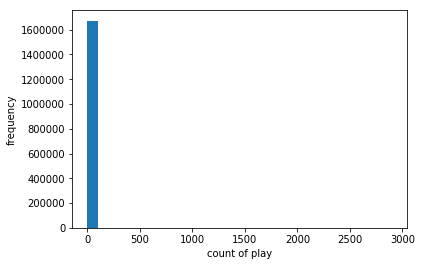

In [57]:
bins, counts = listen_count.select('count').rdd.flatMap(lambda x: x).histogram(30)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.xlabel('count of play')
plt.ylabel('frequency')
plt.show()

*** Most users play song repeatedly for less than 100 times *** 

##### Check the distribution of date in play data

In [58]:
play = play.withColumn('new_date', to_date(F.col('date'), format= 'yyyy-MM-dd'))\
.withColumn('doy', dayofyear(F.col('new_date')))

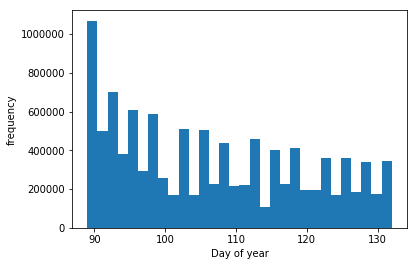

In [59]:
bins, counts = play.select('doy').rdd.flatMap(lambda x: x).histogram(30)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.xlabel('Day of year')
plt.ylabel('frequency')
plt.show()

*** More data were generated from day 90 to day 110 than from day 110 to 130 . Now lets try to see listen frequency in a fixed time window ***

In [24]:
play.columns

['uid',
 'device',
 'song_id',
 'date',
 'play_time',
 'song_length',
 'song_80',
 'listened']

In [25]:
play.describe('date').show()

+-------+----------+
|summary|      date|
+-------+----------+
|  count|  10773206|
|   mean|      null|
| stddev|      null|
|    min|2017-03-30|
|    max|2017-05-12|
+-------+----------+



In [66]:
feature_window_start_date = parser.parse('2017-03-30').date()

In [67]:
time_window = 3
snapshot_date = feature_window_start_date

In [68]:
snapshot_date-datetime.timedelta(time_window-1)

datetime.date(2017, 3, 28)

In [69]:
# define a function to generate frequency features
def frequency_feature_generation(df,time_window,snapshot_date):
    """
    generate frequency features for one event type and one time window
    """
    df_feature = df\
            .filter((F.col('date')<=snapshot_date + datetime.timedelta(time_window-1)) & (F.col('date')>=snapshot_date))\
            .groupBy('uid', 'song_id').count()
    #.withColumnRenamed( 'count', ('last' + str(time_window)))
    return df_feature

In [70]:
time_window_list = [7,14,30]
play_feature_list = []
snapshot_date = [feature_window_start_date, (feature_window_start_date + datetime.timedelta(30))]
for time_window in time_window_list:
    for sn_date in snapshot_date:
        print(time_window, sn_date)
        play_feature_list.append(frequency_feature_generation(play,time_window,sn_date))

7 2017-03-30
7 2017-04-29
14 2017-03-30
14 2017-04-29
30 2017-03-30
30 2017-04-29


In [96]:
for i in df_feature_list:
    i.describe('count').show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|           1295073|
|   mean|2.2777596320825158|
| stddev| 9.140909594342908|
|    min|                 1|
|    max|              3766|
+-------+------------------+

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|            526871|
|   mean|2.4854527958456623|
| stddev| 6.965523346009811|
|    min|                 1|
|    max|              1071|
+-------+------------------+

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|           1768674|
|   mean|2.7248124866425356|
| stddev| 10.75832836502108|
|    min|                 1|
|    max|              3766|
+-------+------------------+

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|            862213|
|   mean| 2.936572517463782|
| stddev|10.261947147206401|
|    min|                 1|
|    max|  

### Download data descriptive analysis

* Download data has the same time frame as the play data

* To combine the data 

In [71]:
download = sql.read.csv('../data/down_ds.csv', header = True)

In [72]:
download.describe('date').show()

+-------+----------+
|summary|      date|
+-------+----------+
|  count|    610855|
|   mean|      null|
| stddev|      null|
|    min|2017-03-30|
|    max|2017-05-12|
+-------+----------+



In [73]:
time_window_list = [7,14,30]
down_feature_list = []
snapshot_date = [feature_window_start_date, (feature_window_start_date + datetime.timedelta(30))]
for time_window in time_window_list:
    for sn_date in snapshot_date:
        print(time_window, sn_date)
        down_feature_list.append(frequency_feature_generation(download,time_window,sn_date))

7 2017-03-30
7 2017-04-29
14 2017-03-30
14 2017-04-29
30 2017-03-30
30 2017-04-29


In [101]:
for i in down_feature_list:
    i.describe('count').show()

+-------+-------------------+
|summary|              count|
+-------+-------------------+
|  count|             291126|
|   mean| 1.0387770243811958|
| stddev|0.23435501081127105|
|    min|                  1|
|    max|                 12|
+-------+-------------------+

+-------+-------------------+
|summary|              count|
+-------+-------------------+
|  count|              45514|
|   mean| 1.0323416970602453|
| stddev|0.21214798556441022|
|    min|                  1|
|    max|                  9|
+-------+-------------------+

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|            374904|
|   mean| 1.045806393103301|
| stddev|0.2584303649745542|
|    min|                 1|
|    max|                12|
+-------+------------------+

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|             79178|
|   mean|1.1463537851423375|
| stddev|0.4568067110291585|
|    min|             

### Generate implicit ratings

* It looks the volumn of download vs. the volumn of play is 200: 1; 
* Is there any correlation between the frequency of download and the frequency of play?

In [74]:
play_feature_list[4] = play_feature_list[4].withColumnRenamed('count', 'play_count')

In [75]:
down_feature_list[4] = down_feature_list[4].withColumnRenamed('count', 'down_count')

In [76]:
### now lets join the play data and download data from 03-30 to 04-30

In [77]:
feature_30_days = play_feature_list[4].join(down_feature_list[4], on = ['uid', 'song_id'], how = 'left')

In [78]:
feature_30_days

DataFrame[uid: string, song_id: string, play_count: bigint, down_count: bigint]

In [79]:
feature_30_days = feature_30_days.withColumn('ratio', F.col('down_count')*200/F.col('play_count'))

In [80]:
feature_30_days.describe('ratio').show()

+-------+------------------+
|summary|             ratio|
+-------+------------------+
|  count|            297319|
|   mean|  97.4274122325831|
| stddev| 83.58308412877254|
|    min|0.0980872976949485|
|    max|            1600.0|
+-------+------------------+



In [143]:
feature_30_days.filter(F.col('ratio').isNotNull()).orderBy('ratio').limit(30).toPandas()

,uid,song_id,play_count,down_count,ratio
0,168990714,4284080,2039,1,0.098087
1,167833788,6933042,1450,1,0.137931
2,167640043,4327992,1062,1,0.188324
3,168562433,5769918,945,1,0.211640
4,168756834,13149231,937,1,0.213447
5,167925975,6402552,917,1,0.218103
6,168047899,7065902,863,1,0.231750
7,168488173,6027117,808,1,0.247525
8,161743399,14634946,786,1,0.254453
9,167991884,23486362,783,1,0.255428


In [133]:
feature_30_days.filter(F.col('ratio').isNotNull()).describe('play_count').show()

+-------+------------------+
|summary|        play_count|
+-------+------------------+
|  count|            297319|
|   mean| 6.313881722997857|
| stddev|13.815512005179238|
|    min|                 1|
|    max|              2039|
+-------+------------------+



*** Here we see that on average, from March 30 to April 30, users who downloaded the song have listerned to that song for at least 6 times. We will use this number to combine the frequency of play and download. ***

In [81]:
feature_30_days = feature_30_days.na.fill(0).withColumn('add_count', F.col('play_count') + 6*F.col('down_count'))

In [153]:
feature_30_days.take(10)

[Row(uid='10199495', song_id='22820742', play_count=2, down_count=0, ratio=0.0, add_count=2),
 Row(uid='102311569', song_id='9950164', play_count=16, down_count=0, ratio=0.0, add_count=16),
 Row(uid='102570564', song_id='217777', play_count=1, down_count=0, ratio=0.0, add_count=1),
 Row(uid='102570564', song_id='4012051', play_count=2, down_count=1, ratio=100.0, add_count=8),
 Row(uid='103953047', song_id='23497878', play_count=2, down_count=0, ratio=0.0, add_count=2),
 Row(uid='104992781', song_id='127709', play_count=1, down_count=0, ratio=0.0, add_count=1),
 Row(uid='104992781', song_id='708290', play_count=43, down_count=0, ratio=0.0, add_count=43),
 Row(uid='106679515', song_id='7074655', play_count=1, down_count=0, ratio=0.0, add_count=1),
 Row(uid='106679515', song_id='7123312', play_count=1, down_count=0, ratio=0.0, add_count=1),
 Row(uid='107621350', song_id='5237384', play_count=15, down_count=0, ratio=0.0, add_count=15)]

Text(0,0.5,'frequency')

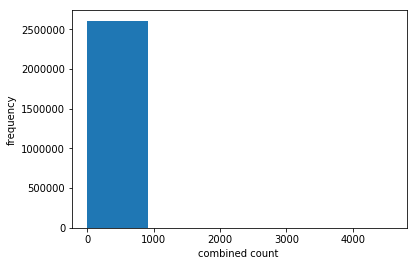

In [82]:
bins, counts = feature_30_days.select('add_count').rdd.flatMap(lambda x: x).histogram(5)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.xlabel('combined count ')
plt.ylabel('frequency')

##### Use quantile discretizer to generate ratings based on combined count

In [85]:
discretizer = QuantileDiscretizer(numBuckets=15, inputCol="add_count", outputCol="rating")
result = discretizer.fit(feature_30_days).transform(feature_30_days)
#result.show()

Text(0,0.5,'frequency')

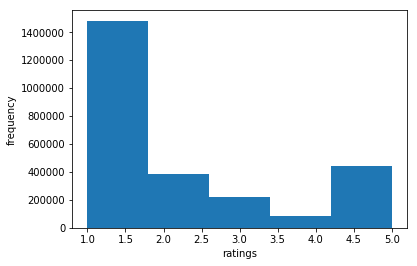

In [86]:
bins, counts = result.select('rating').rdd.flatMap(lambda x: x).histogram(5)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.xlabel('ratings')
plt.ylabel('frequency')

In [87]:
result.groupBy('rating').count().show()

+------+-------+
|rating|  count|
+------+-------+
|   1.0|1482325|
|   4.0|  82798|
|   3.0| 217702|
|   2.0| 382403|
|   5.0| 443050|
+------+-------+



In [169]:
result = result.select('uid', 'song_id', 'rating')

#### Split data into train, cv, testing

* For collaborative filtering, one of the method to validate the model is to ***mask some records*** in the utility matrix and test the data using the entire dataset.
* Here we use records from users who have at least listened to 10 songs. And split them into train, cv and test. This method is actually the same as using mask data. 

In [ ]:
ten_uid = result.groupby('uid', 'song_id').count().filter(F.col('count') >= 10)

In [89]:
ten_uid_list = list(ten_uid.toPandas().uid)
result_sample = result.filter(F.col('uid').isin([ten_uid_list]))

In [225]:
result_sample.write.parquet('result')

In [90]:
result_sample = sql.read.parquet('result')

In [6]:
result_sample = result_sample\
.withColumn('uid', F.col('uid').cast('int'))\
.withColumn('song_id', F.col('song_id').cast('int'))\
.withColumn('rating', F.col('rating').cast('int'))

In [7]:
training, validation, test = result_sample.randomSplit([.6, .2, .2])


In [8]:
training.registerTempTable('train')
validation.registerTempTable('cv')
test.registerTempTable('test')

In [9]:
train_id = sql.sql('SELECT DISTINCT uid from train')

In [10]:
sql.sql('SELECT * from cv \
where uid in (SELECT distinct uid from train)')

DataFrame[uid: int, song_id: int, rating: int]

In [11]:
validation_f = sql.sql('SELECT * from cv \
where uid in (SELECT distinct uid from train)')

In [243]:
validation.count(), validation_f.count()

(504958, 504958)

In [244]:
test_f = sql.sql('SELECT * FROM test WHERE uid in (SELECT DISTINCT uid from train)')

In [245]:
test.count(), test_f.count()

(505565, 505565)

In [22]:
training = training.filter(F.col('song_id').isNotNull())
validation = validation.filter(F.col('song_id').isNotNull())
test = test.filter(F.col('song_id').isNotNull())

In [23]:
validation_for_pred = validation.drop('rating').rdd

### Build model in ALS

In [24]:
from pyspark.mllib.recommendation import ALS
import math

In [31]:
seed = 888
iterations = 10
regularization_parameter = 0.1
ranks = [3, 5, 15]
errors = [0, 0, 0]
err = 0
tolerance = 0.02

min_error = float('inf')
best_rank = -1
best_iteration = -1

In [33]:
for rank in ranks:
    model = ALS.train(training, rank, seed = seed, iterations = 10, lambda_ = regularization_parameter )
    y_pred = model.predictAll(validation_for_pred)
    
    ## join prediction and true target
    y_pred_df = y_pred.toDF()
    y_pred_df = y_pred_df\
    .withColumn('rating', F.col('rating').cast('int'))\
    .withColumnRenamed('rating', 'pred')\
    .withColumnRenamed('user', 'uid')\
    .withColumnRenamed('product', 'song_id')
    y_pred_true = y_pred_df.join(validation, on = ['uid', 'song_id'], how = 'left')
    y_pred_true_rdd = y_pred_true.rdd
    RMSE =  math.sqrt(y_pred_true_rdd.map(lambda Row: ((Row[2] - Row[3])**2)).mean())
    errors[err] = RMSE
    err += 1
    print('For rank %s the RMSE is %s' % (rank, RMSE))
    if RMSE < min_error:
        min_error = RMSE
        best_rank = rank
print('The best model was trained with rank %s' % best_rank)

For rank 3 the RMSE is 1.5182001830250214
For rank 5 the RMSE is 1.5344501711926442
For rank 15 the RMSE is 1.552673493374397
The best model was trained with rank 3


### Now use one of the best model on test data

In [26]:
test_for_pred = test.drop('rating').rdd

In [34]:
model = ALS.train(training, 3, seed = seed, iterations = 10, lambda_ = regularization_parameter )
y_pred = model.predictAll(test_for_pred)
    
## join prediction and true target
y_pred_df = y_pred.toDF()
y_pred_df = y_pred_df\
    .withColumn('rating', F.col('rating').cast('int'))\
    .withColumnRenamed('rating', 'pred')\
    .withColumnRenamed('user', 'uid')\
    .withColumnRenamed('product', 'song_id')
y_pred_true = y_pred_df.join(test, on = ['uid', 'song_id'], how = 'left')
y_pred_true_rdd = y_pred_true.rdd
RMSE =  math.sqrt(y_pred_true_rdd.map(lambda Row: ((Row[2] - Row[3])**2)).mean())
  
print('For rank %s the RMSE is %s' % (3, RMSE))

For rank 3 the RMSE is 1.5162540308406331
